# Section 0: Setup

**Note: If you want to run this code you must get an API Key from FRED.**

In [ ]:

from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose


# Section 1: Load Data

In [2]:
EGG_SERIES_ID = "APU0000708111"

df = fred.get_series(EGG_SERIES_ID)

df.index = pd.to_datetime(df.index)
df = df.asfreq("MS")

df.index.name = "date"

df = (
    df.to_frame("price_usd")
      .sort_index()
      .dropna()
)


In [3]:
df.head()

,price_usd
date,
1980-01-01,0.879
1980-02-01,0.774
1980-03-01,0.812
1980-04-01,0.797
1980-05-01,0.737


# Section 2: Visual EDA

<Axes: title={'center': 'Average Price of df (USD per dozen)'}, xlabel='Date', ylabel='Price'>

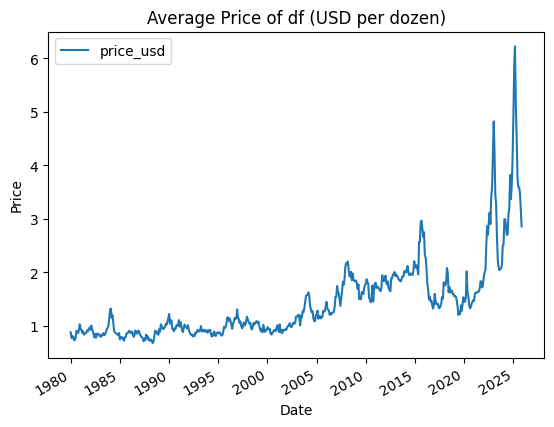

In [4]:
# visualize the raw data
df.plot(title="Average Price of df (USD per dozen)", xlabel="Date", ylabel="Price")

In [5]:
rolling_mean = df['price_usd'].rolling(12).mean()
rolling_std = df['price_usd'].rolling(12).std()

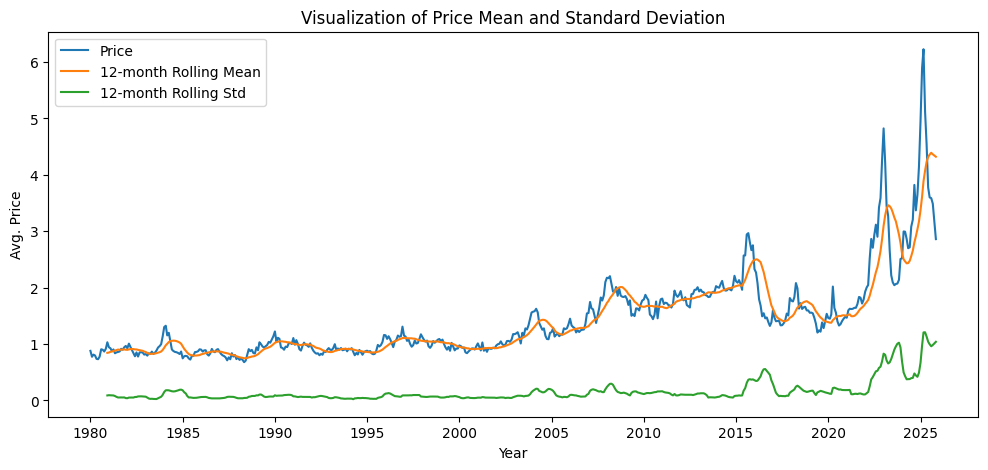

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df["price_usd"], label="Price")
plt.plot(rolling_mean, label="12-month Rolling Mean")
plt.plot(rolling_std, label="12-month Rolling Std")
plt.title('Visualization of Price Mean and Standard Deviation')
plt.xlabel("Year")
plt.ylabel("Avg. Price")
plt.legend()

Prices trend upward over time and show increasing volatility, indicating non-stationarity.

# Section 3: Transformations

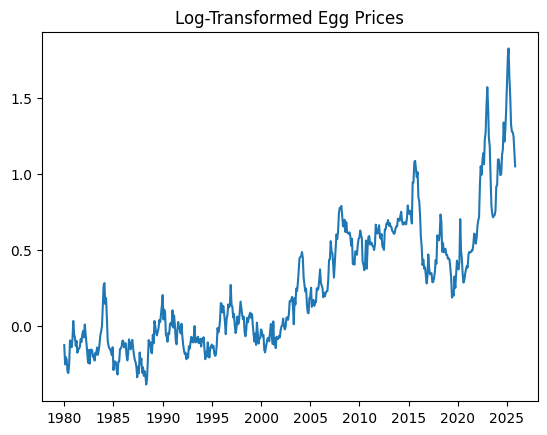

In [7]:
df['log_price'] = np.log(df['price_usd'])
plt.figure()
plt.plot(df.index, df['log_price'])
plt.title("Log-Transformed Egg Prices")
plt.show()


<Axes: title={'center': 'Log of Average Price Difference of Eggs (USD per dozen)'}, xlabel='Date', ylabel='Log Change in Price'>

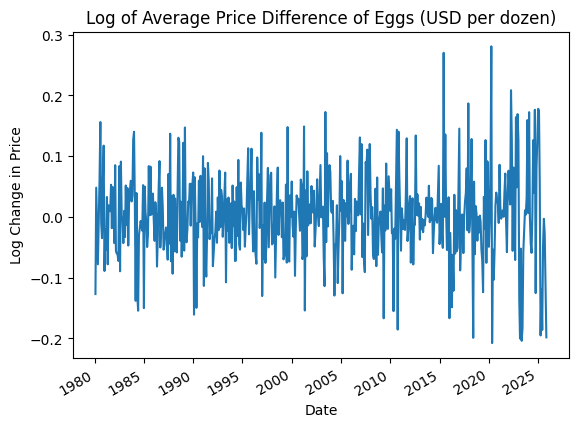

In [8]:
df['log_diff_1'] = df['log_price'].diff()
df['log_diff_1'].plot(title="Log of Average Price Difference of Eggs (USD per dozen)", xlabel="Date", ylabel="Log Change in Price")


<Axes: title={'center': 'Egg Price Changes After Accounting for Trend and Seasonality'}, xlabel='Date', ylabel='Log Change in Price'>

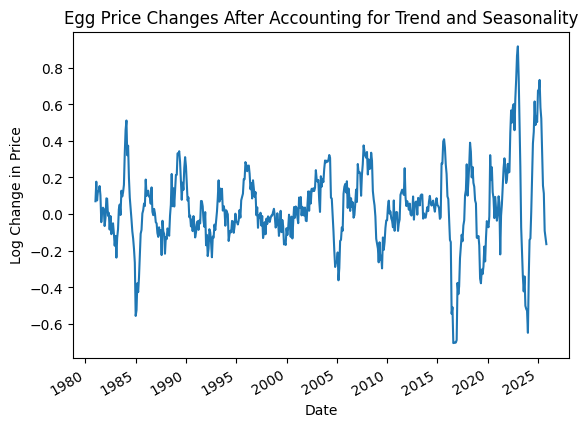

In [9]:
df['log_diff_12'] = df['log_price'].diff(12)
df['log_diff_12'].plot(title="Egg Price Changes After Accounting for Trend and Seasonality", xlabel="Date", ylabel="Log Change in Price")

A log transform stabilizes variance, and first and seasonal differencing remove trend and annual seasonality. These steps are necessary for ARIMA-style models.

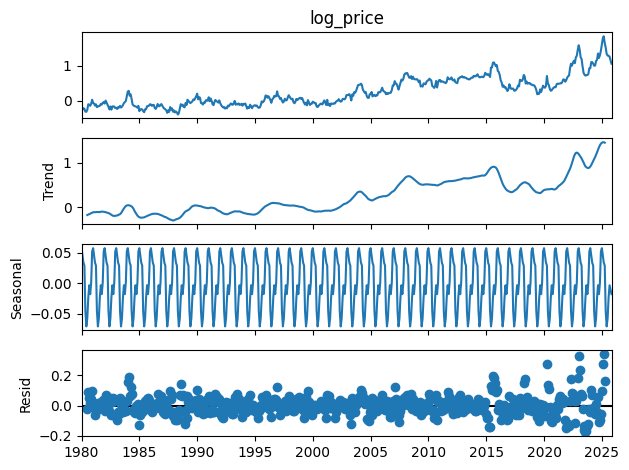

In [10]:
decomp = seasonal_decompose(df['log_price'], model='additive', period=12)
decomp.plot()
plt.show()

# Section 4: Stationarity Checks

In [11]:
def run_adfuller(series):
    series = series.dropna()
    stat, pval, lags, nobs, *_ = adfuller(series)
    return pd.Series([stat, pval, lags, nobs],
                     index=["ADF Statistic", "p-value", "# Lags Used", "# Observations"])


In [12]:
adf_table = pd.DataFrame({
    "Raw Price": run_adfuller(df["price_usd"]),
    "Log Price": run_adfuller(df["log_price"]),
    "Log Diff (1)": run_adfuller(df["log_diff_1"]),
    "Log Diff (12)": run_adfuller(df["log_diff_12"]),
}).T

In [13]:
adf_table

,ADF Statistic,p-value,# Lags Used,# Observations
Raw Price,0.465796,9.837956e-01,18.0,531.0
Log Price,-0.114919,9.479321e-01,18.0,531.0
Log Diff (1),-8.136669,1.054699e-12,17.0,531.0
Log Diff (12),-5.341380,4.492312e-06,16.0,521.0


After first and seasonal differencing, the series is stationary, justifying SARIMA.

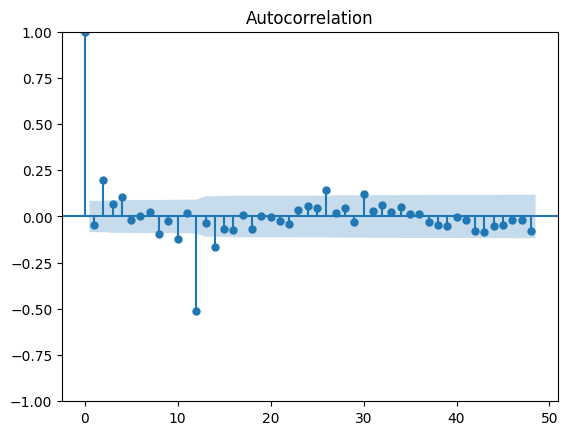

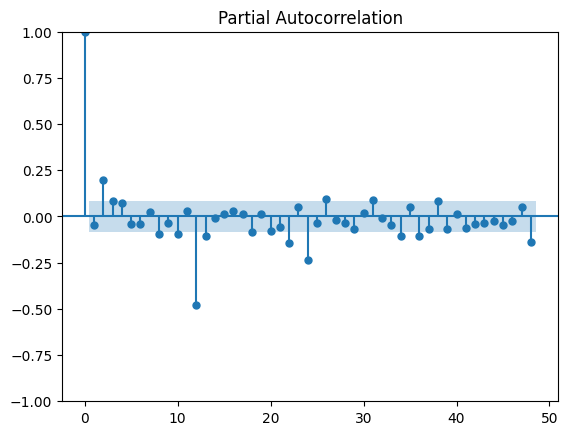

In [14]:
series = (
    (df['log_price'])
    .diff()
    .diff(12)
    .dropna()
)

sm.graphics.tsa.plot_acf(series, lags=48)
sm.graphics.tsa.plot_pacf(series, lags=48)
plt.show()


# Section 5: Modeling

I compare ARIMA and SARIMA specifications and select a seasonal model based on information criteria and residual behavior.

In [15]:
model_arima = ARIMA(
    df["log_price"],
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_arima = model_arima.fit()
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  550
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 668.213
Date:                Wed, 31 Dec 2025   AIC                          -1330.426
Time:                        14:55:35   BIC                          -1317.513
Sample:                             0   HQIC                         -1325.379
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0632      9.674     -0.007      0.995     -19.024      18.897
ma.L1          0.0602      9.673      0.006      0.995     -18.898      19.018
sigma2         0.0051      0.000     20.449      0.0

/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq

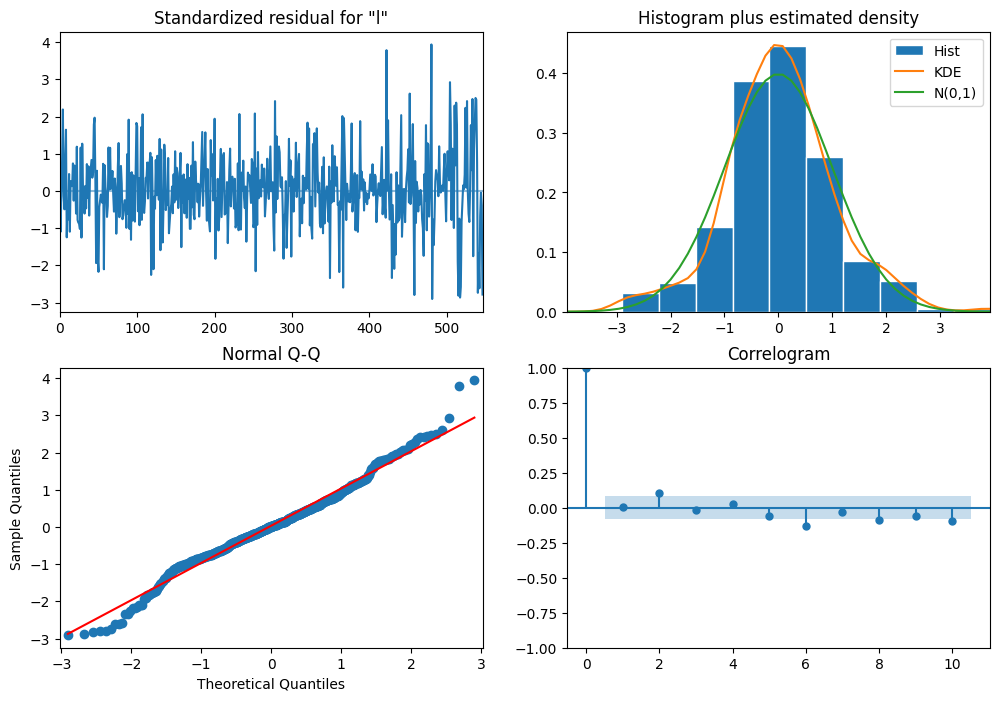

In [16]:
results_arima.plot_diagnostics(figsize=(12,8))
plt.show()

/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  550
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 669.299
Date:                            Wed, 31 Dec 2025   AIC                          -1332.597
Time:                                    14:55:35   BIC                          -1319.818
Sample:                                         0   HQIC                         -1327.592
                                            - 550                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0603      0.038     -1.584      0.113      -0.135       0.014
ma.S.L12      -0.9476      0.027   

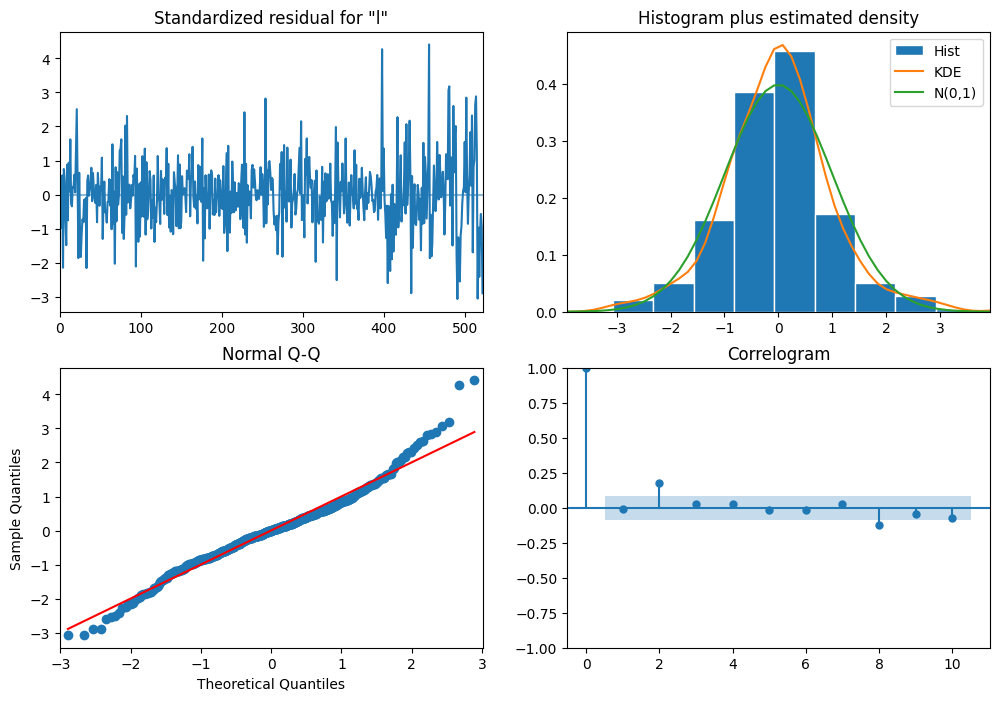

In [17]:
# (0,1,1)x(0,1,1,12)
model_sarima = SARIMAX(
    df["log_price"],
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit()
print(results_sarima.summary())
results_sarima.plot_diagnostics(figsize=(12,8))
plt.show()

/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 670.960
Date:                            Wed, 31 Dec 2025   AIC                          -1331.920
Time:                                    14:55:37   BIC                          -1310.622
Sample:                                         0   HQIC                         -1323.579
                                            - 550                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5367      0.237     -2.265      0.024      -1.001      -0.072
ma.L1          0.4258      0.249   

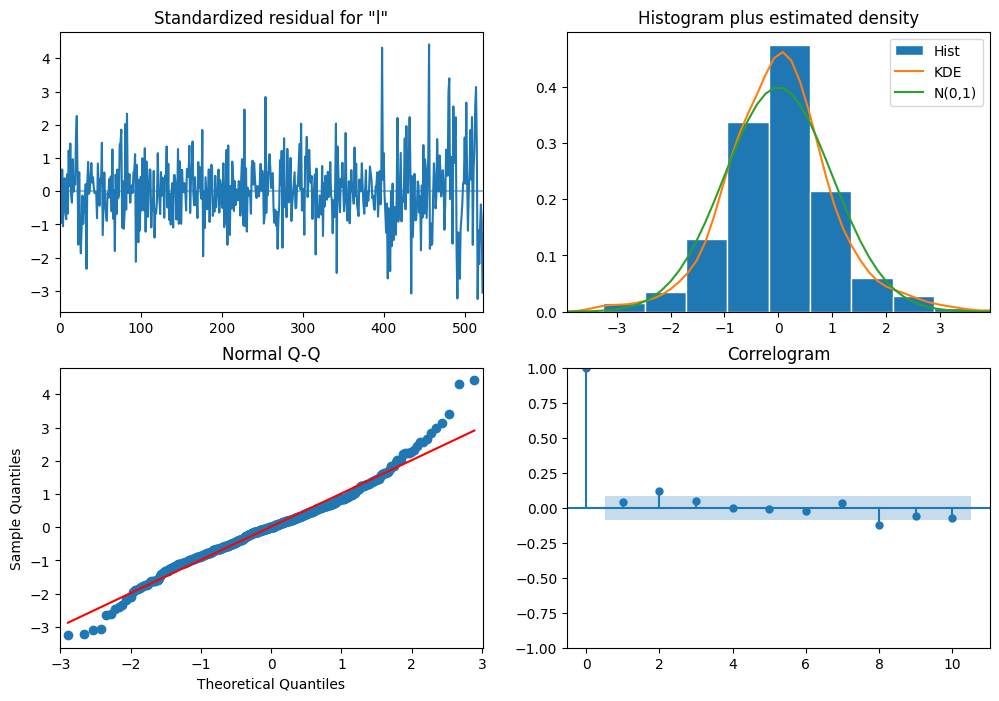

In [18]:
# (1,1,1)x(1,1,1,12)
model_sarima_2 = SARIMAX(
    df["log_price"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_2 = model_sarima_2.fit()
print(results_sarima_2.summary())
results_sarima_2.plot_diagnostics(figsize=(12,8))
plt.show()

/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 687.428
Date:                            Wed, 31 Dec 2025   AIC                          -1364.856
Time:                                    14:55:37   BIC                          -1343.444
Sample:                                         0   HQIC                         -1356.478
                                            - 550                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5729      0.216     -2.657      0.008      -0.996      -0.150
ma.L1          0.4671      0.229   

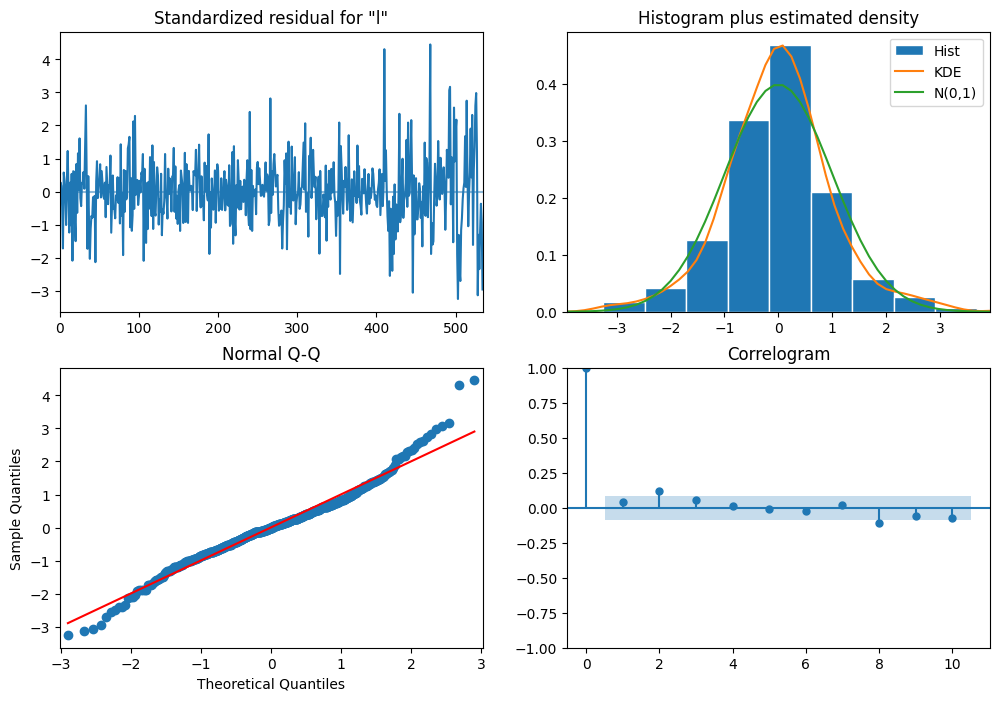

In [19]:
# (1,1,1)x(1,0,1,12)
model_sarima_3 = SARIMAX(
    df["log_price"],
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_3 = model_sarima_3.fit()
print(results_sarima_3.summary())
results_sarima_3.plot_diagnostics(figsize=(12,8))
plt.show()

/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                            log_price   No. Observations:                  550
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 671.149
Date:                              Wed, 31 Dec 2025   AIC                          -1336.298
Time:                                      14:55:38   BIC                          -1323.514
Sample:                                           0   HQIC                         -1331.292
                                              - 550                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0815      0.039     -2.095      0.036      -0.158      -0.005
ma.S.L12      -0.94

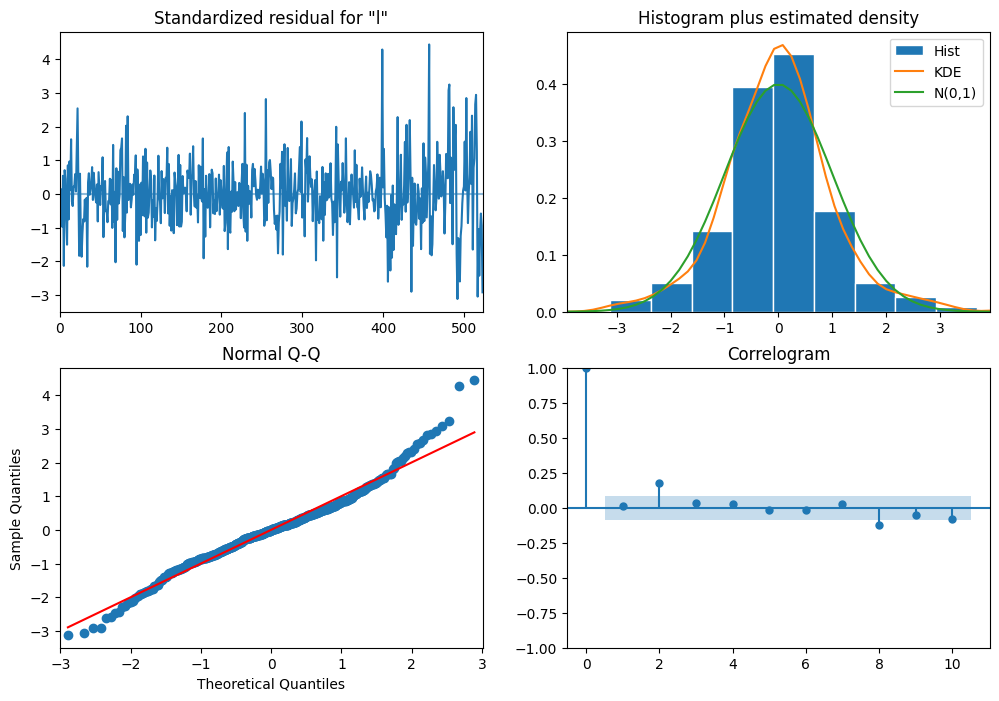

In [20]:
# (1,1,0)x(0,1,1,12)
model_sarima_4 = SARIMAX(
    df["log_price"],
    order=(1,1,0),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_4 = model_sarima_4.fit()
print(results_sarima_4.summary())
results_sarima_4.plot_diagnostics(figsize=(12,8))
plt.show()

In [21]:
print("ARIMA  AIC:", results_arima.aic, "BIC:", results_arima.bic)
print("SARIMA (0,1,1)x(0,1,1,12) AIC:", results_sarima.aic, "BIC:", results_sarima.bic)
print("SARIMA (1,1,1)x(1,1,1,12) AIC:", results_sarima_2.aic, "BIC:", results_sarima_2.bic)
print("SARIMA (0,1,1)x(1,0,1,12) AIC:", results_sarima_3.aic, "BIC:", results_sarima_3.bic)
print("SARIMA (1,1,0)x(0,1,1,12) AIC:", results_sarima_4.aic, "BIC:", results_sarima_4.bic)


ARIMA  AIC: -1330.426435397378 BIC: -1317.5130889901122
SARIMA (0,1,1)x(0,1,1,12) AIC: -1332.5970282086691 BIC: -1319.8182838164744
SARIMA (1,1,1)x(1,1,1,12) AIC: -1331.9196840288203 BIC: -1310.6217767084956
SARIMA (0,1,1)x(1,0,1,12) AIC: -1364.8555194634096 BIC: -1343.4441857289296
SARIMA (1,1,0)x(0,1,1,12) AIC: -1336.298317847775 BIC: -1323.5138427948118


A seasonal model offers a slight improvement in fit, but the gains are small. This reflects that recent egg price dynamics are driven more by shocks than by stable seasonal patterns.

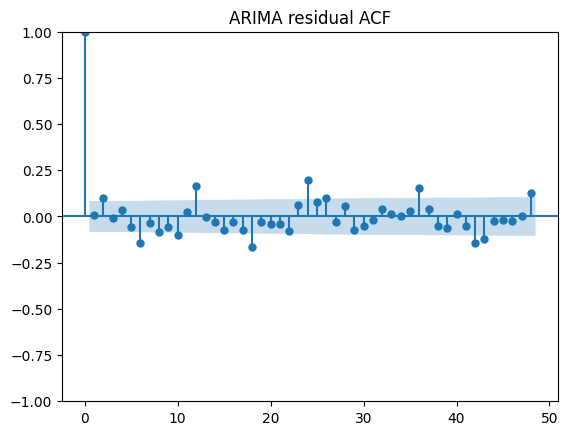

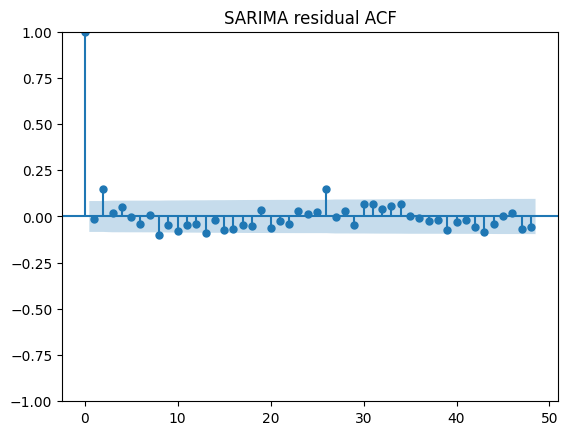

In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(results_arima.resid.dropna(), lags=48)
plt.title("ARIMA residual ACF")
plt.show()

sm.graphics.tsa.plot_acf(results_sarima.resid.dropna(), lags=48)
plt.title("SARIMA residual ACF")
plt.show()


# Section 6: Out-of-Sample Forecast

In [23]:
train = df.loc[: "2019-12-01"].copy()
test  = df.loc["2020-01-01":].copy()


In [24]:
model = SARIMAX(
    train["log_price"],
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)


/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rebekaheichberg/Library/Caches/pypoetry/virtualenvs/prophet-forecasting-7VFiil4--py3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
n_test = len(test)
forecast_res = res.get_forecast(steps=n_test)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Put forecast on the same index as test
forecast_mean.index = test.index
forecast_ci.index = test.index


In [26]:
# --- Baselines (price space) ---
naive_pred = test["price_usd"].shift(1)
snaive_pred = test["price_usd"].shift(12)

# --- Convert SARIMA forecast to price space ---
sarima_price_naive = np.exp(forecast_mean)

forecast_var = forecast_res.var_pred_mean
forecast_var.index = test.index
sarima_price_bc = np.exp(forecast_mean + 0.5 * forecast_var)


In [27]:
comparison = pd.DataFrame({
    "Actual": test["price_usd"],
    "SARIMA": sarima_price_naive,
    "SARIMA (bias-corrected)": sarima_price_bc,
    "Naive (Last Value)": naive_pred,
    "Seasonal Naive (Last Year)": snaive_pred
})

In [28]:
def compute_mae(y_true, y_pred):
    """Compute MAE after aligning and dropping NaNs / infs."""
    mask = (
        y_true.notna()
        & y_pred.notna()
        & ~np.isinf(y_true)
        & ~np.isinf(y_pred)
    )
    return mean_absolute_error(y_true[mask], y_pred[mask])

mae = {
    "SARIMA": compute_mae(
        comparison["Actual"],
        comparison["SARIMA"]
    ),
    "SARIMA (bias-corrected)": compute_mae(
        comparison["Actual"],
        comparison["SARIMA (bias-corrected)"]
    ),

    "Naive (Last Value)": compute_mae(
        comparison["Actual"].iloc[1:],
        comparison["Naive (Last Value)"].iloc[1:]
    ),
    "Seasonal Naive (Last Year)": compute_mae(
        comparison["Actual"].iloc[12:],
        comparison["Seasonal Naive (Last Year)"].iloc[12:]
    ),
}

print("MAE (USD per dozen) — Test period (2020+):")
for model, score in mae.items():
    print(f"{model:30s} {score:6.2f}")


MAE (USD per dozen) — Test period (2020+):
SARIMA                           1.18
SARIMA (bias-corrected)          1.12
Naive (Last Value)               0.26
Seasonal Naive (Last Year)       1.05


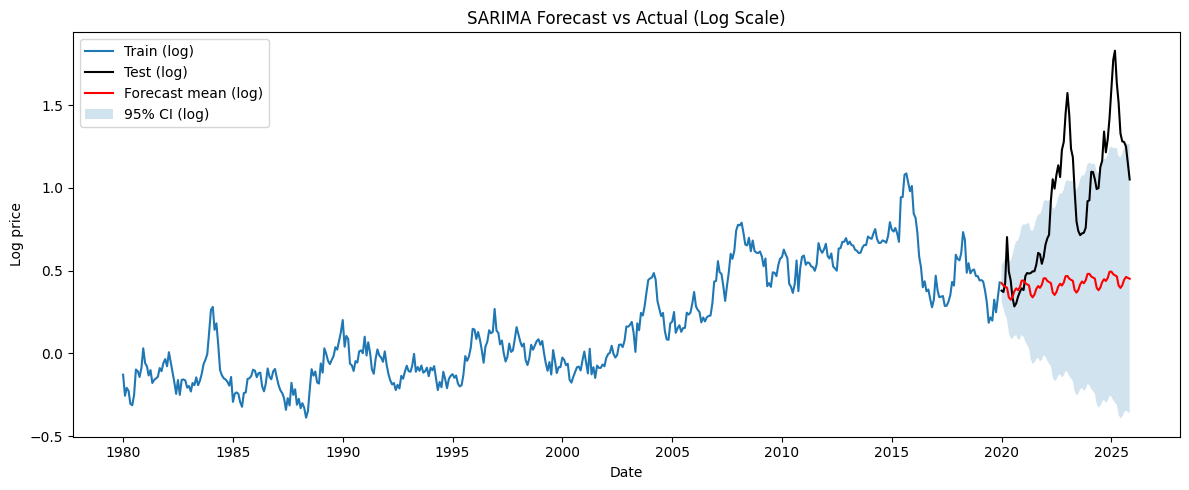

In [29]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train["log_price"], label="Train (log)")
plt.plot(test.index, test["log_price"], label="Test (log)", color="black")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast mean (log)", color="red")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% CI (log)"
)
plt.title("SARIMA Forecast vs Actual (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Log price")
plt.legend()
plt.tight_layout()
plt.show()


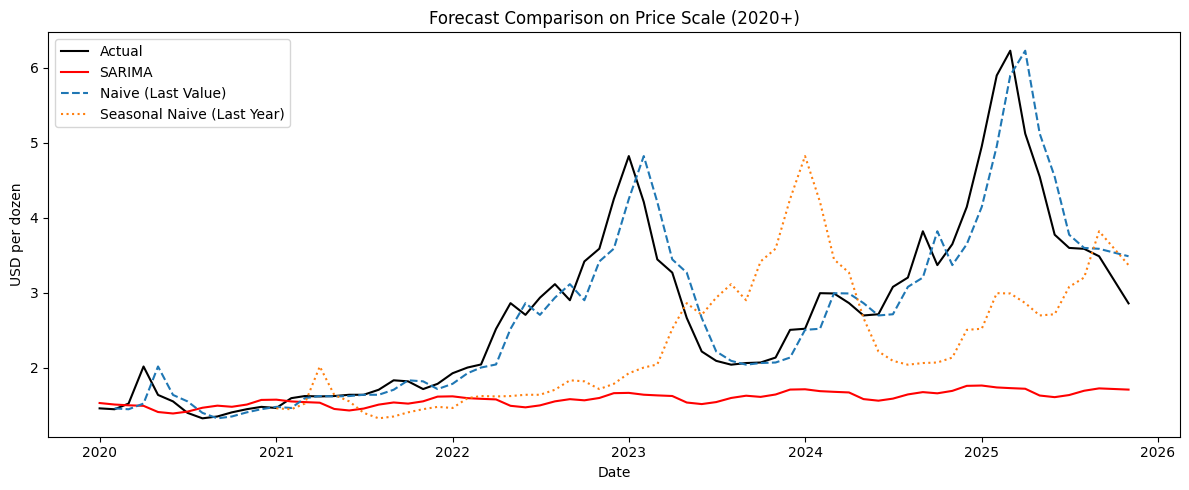

In [30]:
plt.figure(figsize=(12,5))
plt.plot(comparison["Actual"], label="Actual", color="black")
plt.plot(comparison["SARIMA (bias-corrected)"], label="SARIMA", color="red")
plt.plot(comparison["Naive (Last Value)"], label="Naive (Last Value)", linestyle="--")
plt.plot(comparison["Seasonal Naive (Last Year)"], label="Seasonal Naive (Last Year)", linestyle=":")
plt.title("Forecast Comparison on Price Scale (2020+)")
plt.xlabel("Date")
plt.ylabel("USD per dozen")
plt.legend()
plt.tight_layout()
plt.show()

The SARIMA model produces a smooth baseline forecast but fails to anticipate large post-2020 price spikes. During shock-dominated periods, a simple last-value baseline performs better on one-step-ahead error by immediately absorbing level shifts. This example illustrates that forecasting performance depends as much on market structure and regime stability as on model choice.